In [1]:
import os
import xml.etree.ElementTree as ET
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt

In [2]:
root_path = 'e:\\COMP\\COMP9444\\project\\dumpsite_data\\VOC2012'
train_path = os.path.join(root_path, "train")
test_path = os.path.join(root_path, "test")
file_Annotations = os.path.join(train_path, "Annotations")

In [3]:
object_class = []
for each_xml in os.listdir(file_Annotations):
    pic_xml = os.path.join(file_Annotations, each_xml)
    tree = ET.parse(pic_xml)
    root = tree.getroot()
    for object_elem in root.findall('object'):
        name_elem_value = object_elem.find('name').text
        object_class.append(name_elem_value)
classes = set(object_class)
print(classes)


{'domestic garbage', 'disposed garbage', 'industry waste', 'mining waste', 'construction waste', 'agriculture forestry'}


In [4]:
label_maps = {}
for index, class_name in enumerate(classes):
    label_maps[class_name] = index
print(label_maps)

{'domestic garbage': 0, 'disposed garbage': 1, 'industry waste': 2, 'mining waste': 3, 'construction waste': 4, 'agriculture forestry': 5}


In [5]:
def label_name(label_num):
    class_name = {k for k, v in label_maps.items() if v == label_num}
    return list(class_name)[0]

##### Due to the problem of severe sample imbalance in the dumpsite dataset (Fig. 1a), we propose two training strategies, data augmentation (vertical flipping, horizontal
##### flipping, forward 90° rotation and reverse 90° rotation) and category balancing, to ensure the model’sefficiency during the training process

In [6]:
class  VOCDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        txt_file = os.path.join(root, "train.txt")
        with open(txt_file, 'r') as f:
            self.image_ids = f.read().strip().split()
        self.image_folder = os.path.join(root, "JPEGImages")
        self.ann_folder = os.path.join(root, "Annotations")

    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.image_folder, f"{img_id}.jpg")
        ann_path = os.path.join(self.ann_folder, f"{img_id}.xml")

        img = np.array(Image.open(img_path).convert("RGB"))
        tree = ET.parse(ann_path)
        root = tree.getroot()
        boxes = []
        labels = []
        for obj in root.findall("object"):
            label = obj.find("name").text
            print("label是:", label)
            labels.append(label_maps[label])
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            if self.transforms:
                transform = self.transforms.normalize.transforms[0]
                if isinstance(transform, T.Resize):
                    print("等比例缩放")
                    scale_factor = transform.size[0] / img.width
                    print(scale_factor)
                    xmin = int(xmin * scale_factor)
                    ymin = int(ymin * scale_factor)
                    xmax = int(xmax * scale_factor)
                    ymax = int(ymax * scale_factor)
            box = [xmin, ymin, xmax, ymax]
            boxes.append(box)
        
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int)
        target = {"boxes":boxes, "labels":labels}
        if self.transforms:
            img, target = self.transforms(img, target)
        return {'image':img, 'boxes':target['boxes'], 'labels':target['labels']}

In [7]:
class DetectionTransforms:
    def __init__(self):
        self.augment = A.Compose([
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5), 
            A.Rotate(limit=90, p=0.5),
            A.Rotate(limit=-90, p=0.5), 
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
        self.normalize = A.Compose([
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
    
    def __call__(self, image, targets):
        # albumentations  request the type of image is numpy not PIL
        transformed = self.augment(image=image, bboxes=targets['boxes'], labels=targets['labels'])
        image = transformed['image']
        targets['boxes'] = transformed['bboxes']
        targets['labels'] = transformed['labels']
        image = self.normalize(image=image)['image']
        return image, targets

In [8]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def unnormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return image * std + mean

def collate_fn(batch):
    images = []
    targets = []
    for obj in batch:
        images.append(obj['image'])
        targets.append({'boxes':obj['boxes'], 'labels':obj['labels']})
    images = torch.stack(images, dim=0)
    return images, targets


transforms = DetectionTransforms()
dataset = VOCDataset(root='./dumpsite_data/VOC2012/train', transforms=transforms)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

#### 原图与处理后的图片对比（含有边框）

label是: domestic garbage


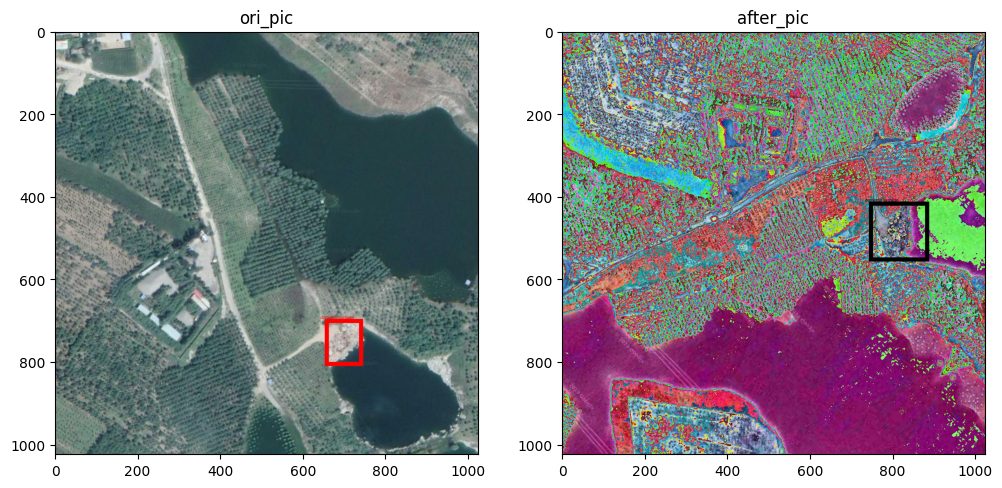

In [23]:
def compare_pic():
    random_idx = random.randint(0, len(dataset) - 1)
    ori_pic = os.path.join("E:/COMP/COMP9444/project/dumpsite_data/VOC2012/train/JPEGImages", f'{dataset.image_ids[random_idx]}.jpg')
    ori_pic_ann = os.path.join("E:/COMP/COMP9444/project/dumpsite_data/VOC2012/train/Annotations", f"{dataset.image_ids[random_idx]}.xml")
    ori_pic = Image.open(ori_pic).convert("RGB")
    tree = ET.parse(ori_pic_ann)
    root = tree.getroot()
    ori_boxes = []
    ori_labels = []
    for bounding_box in root.findall('object'):
        label = bounding_box.find("name").text
        ori_labels.append(label)
        bbox = bounding_box.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)
        box = [xmin, ymin, xmax, ymax]
        ori_boxes.append(box)
    ori_draw = ImageDraw.Draw(ori_pic)
    for box, label in zip(ori_boxes, ori_labels):
        xmin, ymin, xmax, ymax = box
        ori_draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=10)
        ori_draw.text((xmin - 10, ymin - 10), label, fill="red")
    img, boxes, labels = dataset[random_idx].values()
    image = unnormalize(img, mean, std).permute(1, 2, 0).numpy()
    image = (image * 255).astype(np.uint8)
    # image = img.permute(1, 2, 0).numpy()
    image = F.to_pil_image(img)
    draw = ImageDraw.Draw(image)
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        draw.rectangle([xmin, ymin, xmax, ymax], outline="black", width=10)
        draw.text((xmin - 10, ymin - 10), label_name(label), fill="black")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(ori_pic)
    ax1.set_title('ori_pic')
    ax2.imshow(image)
    ax2.set_title('after_pic')
    plt.show()

compare_pic()

In [11]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn